<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 3.0 Transformer Decoder

In this notebook, you'll complete your examination of the architecture with a look at the decoder and masked multi-headed attention.  Finally, you'll run inference for the NMT English-German task.

**[3.1 Overview](#3.1-Overview)<br>**
**[3.2 Masked Multi-Head Attention](#3.2-Masked-Multi-Head-Attention)<br>**
**[3.3 References](#3.3-References)**<br>

# 3.1 Overview

The decoder operates in a similar way to the encoder, but generates one word at a time, from left to right. It attends not only to the other previously generated words, but also to the final representations generated by the encoder. 

<center><img src="images/enc_dec_2.png" width="800"></center>
<center> Figure 6. Decoder block illustration. </center>

After finishing the encoding phase, the decoding phase starts. The decoder has a very similar structure to the encoder. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, there are residual connections around each of the sub-layers, followed by layer normalization.

The `TransformerDecoder` class is shown below. For simplicity, lines related to values read from `args` have been removed, as well as some normalization and data transpositions. Please refer to the [original implementation](https://github.com/NVIDIA/DeepLearningExamples/blob/8c3514071275b2805b29372f6dabe515d431416f/PyTorch/Translation/Transformer/fairseq/models/transformer.py#L298) to see these lines.

Note that `self.layers` is a `nn.ModuleList`, comprised of `args.decoder_layers` (default 6) copies of `TransformerDecorderLayer`. 

In [1]:
# Import libraries
import os
import io
import sys
import PIL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Dict
import math, copy, time

from encoder_demos.demo_fairseq.models.fairseq_model import BaseFairseqModel, FairseqDecoder, FairseqEncoder
from encoder_demos.demo_fairseq.models.fairseq_incremental_decoder import FairseqIncrementalDecoder

In [2]:
from torch import Tensor
from typing import Optional, Dict
class TransformerDecoder(FairseqIncrementalDecoder):
    """Transformer decoder."""

    def __init__(self, args, embed_tokens, no_encoder_attn=False, left_pad=False):
        super().__init__()
        self.dropout = args.dropout
        self.share_input_output_embed = args.share_decoder_input_output_embed
        self.fuse_dropout_add = args.fuse_dropout_add
        self.fuse_relu_dropout = args.fuse_relu_dropout

        embed_dim = embed_tokens.embedding_dim
        padding_idx = embed_tokens.padding_idx
        self.max_target_positions = args.max_target_positions

        self.embed_tokens = embed_tokens
        self.embed_scale = math.sqrt(embed_dim)
        self.embed_positions = PositionalEmbedding(
            args.max_target_positions, embed_dim, padding_idx,
            left_pad=left_pad,
            learned=args.decoder_learned_pos,
        ) if not args.no_token_positional_embeddings else None

        self.layers = nn.ModuleList([])
        self.layers.extend([
            TransformerDecoderLayer(args, no_encoder_attn)
            for _ in range(args.decoder_layers)
        ])


    def forward(self,
                prev_output_tokens: Tensor,
                encoder_out: Tensor,
                encoder_padding_mask: Tensor,
                incremental_state: Optional[Dict[str, Dict[str, Tensor]]]=None):
        # embed positions
        positions = self.embed_positions(
            prev_output_tokens,
            incremental_state=incremental_state,
        ) if self.embed_positions is not None else None

        if incremental_state is not None:
            prev_output_tokens = prev_output_tokens[:, -1:]
            if positions is not None:
                positions = positions[:, -1:]

        # embed tokens and positions
        x = self.embed_scale * self.embed_tokens(prev_output_tokens)
        if positions is not None:
            x += positions
        x = F.dropout(x, p=self.dropout, training=self.training)

        # B x T x C -> T x B x C
        # The tensor needs to copy transposed because
        # fused dropout is not capable of handing strided data
        if self.fuse_dropout_add :
            x = x.transpose(0, 1).contiguous()
        else :
            x = x.transpose(0, 1)
        attn = None

        # decoder layers
        for layer in self.layers:
            x, attn = layer(
                x,
                encoder_out,
                encoder_padding_mask if encoder_padding_mask.any() else None,
                incremental_state,
            )


        return x, attn

Each `TransformerDecoderLayer` is a copy of the TransformerDecoderLayer class defined [here](https://github.com/NVIDIA/DeepLearningExamples/blob/8c3514071275b2805b29372f6dabe515d431416f/PyTorch/Translation/Transformer/fairseq/models/transformer.py#L487). The full implementation includes optional layer normalization, but we have removed this for the sake of simplicity.

Looking at the `forward` method, the embedded tokens `x` are passed through the self-attention mechanism and then later `fc1` and `fc2`, in a very similar way to the `TransformerEncoderLayer`. The difference in the decoder is that there is an attention process between the self-attention and the fully connected layers. This introduces the multi-head attention which decodes `x`, eventually producing intelligible output.

Each step in the decoding phase outputs an element from the output sequence, which is the English translation sentence in our case. The encoder starts by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors K and V. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence.

The Decoder side of the Figure 1 would perform the following operations successively: 

Step1_out = OutputEmbedding512 + PositionEncoding512

Step2_Mask = masked_multihead_attention(Step1_out)

Step2_Norm1 = layer_normalization(Step2_Mask) + Step1_out

Step2_Multi = multihead_attention(Step2_Norm1 + out_enc) +  Step2_Norm1

Step2_Norm2 = layer_normalization(Step2_Multi) + Step2_Multi

Step3_FNN = FNN(Step2_Norm2)

Step3_Norm = layer_normalization(Step3_FNN) + Step2_Norm2

out_dec = Step3_Norm

# 3.2 Masked Multi-Head Attention

You might have noticed the "masked multi-head attention" layer in the decoder. Self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position <i>i</i> can depend only on the known outputs at positions less than <i>i</i>. In other words, masked multi-head attention is applied to prevent future words to be part of the attention.

In [3]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.tril(np.ones((1,10,10))).astype('uint8')    
    return torch.as_tensor(subsequent_mask)

In [4]:
subsequent_mask(10)[0]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

What masking does is to zero-out the similarities between words and the words that appear after the source words ("in the future"). It simply removes such information, so it cannot be used by the model, only similarity to the preceding words is considered.

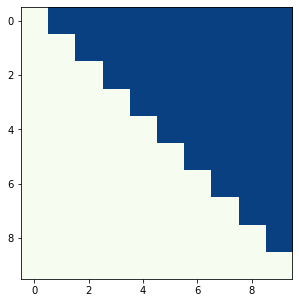

In [5]:
plt.figure(figsize=(5,5))
cmap = plt.cm.GnBu_r
plt.imshow(subsequent_mask(10)[0], cmap=cmap)
None

The animation below illustrates how the Transformer is applied to machine translation. The Transformer starts by generating initial representations, or embeddings, for each word. These are represented by the unfilled circles. Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

![Encoderflow](https://3.bp.blogspot.com/-aZ3zvPiCoXM/WaiKQO7KRnI/AAAAAAAAB_8/7a1CYjp40nUg4lKpW7covGZJQAySxlg8QCLcBGAs/s1600/transform20fps.gif)
<center> Figure 7. Transformer step-by-step sequence English-to-French translation. </center>

 Credit: [Google Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)

# 3.3 References

1. [Attention is all you need](https://arxiv.org/abs/1706.03762)
2. [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
3. [Word2Vec](https://arxiv.org/pdf/1310.4546.pdf)
4. [GloVe](https://nlp.stanford.edu/projects/glove/)
5. [fastText](https://fasttext.cc/)
6. [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162)
7. [The Annotated Transformer - Harvard NLP](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

<h2 style="color:green;">Congratulations!</h2>

You've completed the final Tranformer notebook!  
You've learned 
* Decoders have three sublayers
* Decoders attend previously generated words and the final representations generated by the encoder
* Decoders use masked multi-head attention to prevent future words from being included

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>